### Импорт необходимых библиотек и загрузка датасета

In [ ]:
!pip install opendatasets

In [ ]:
import tensorflow as tf # библиотека Tensorflow
import keras # библиотека Keras
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU,Rescaling, Dropout, concatenate # cлои библиотеки Keras
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate, Lambda # cлои библиотеки Keras
from keras.layers import Rescaling, Resizing # cлои библиотеки Keras
from keras.models import Model, Sequential # конструкторы построения моделей библиотеки Keras

from keras.optimizers import Adam # оптимизатор Adam
from keras.preprocessing.image import  load_img # загрузка изображений
from keras.utils import to_categorical # преобразует вектор класса (целые числа) в двоичную матрицу класса
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # Колл-бэки
from tensorflow.keras import backend as K

import random # генератор случайных чисел

import numpy as np # библиотека линейной алгебры
import pandas as pd # библиотека обработки табличных данных
import os # библиотека работы с функциями операционной системы, в том числе с файлами
import albumentations as A # библиотека аугментации изображений (https://albumentations.ai/)

import matplotlib.pyplot as plt # библиотека для рисования графиков
%matplotlib inline

import opendatasets as op

Загрузим датасет с данными о радиографическом исследовании по COVID-19.

In [ ]:
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: asugyfuyasdgf
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


Структура папок

In [ ]:
dataset_path = './covid19-radiography-database/COVID-19_Radiography_Dataset/Normal'

image_dir = 'images'
label_dir = 'masks'

### Визуализация данных

Посмотрим на данные, из которых состоит наш датасет.

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная маска']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[0]))            # отображаем картинку
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]),alpha=0.5)  # отображаем маску с прозрачностью 50%
    plt.axis('off')
  plt.show()                                                            # выводим график целиком

Отрисуем пример с оригинальным изображением и маской к нему.

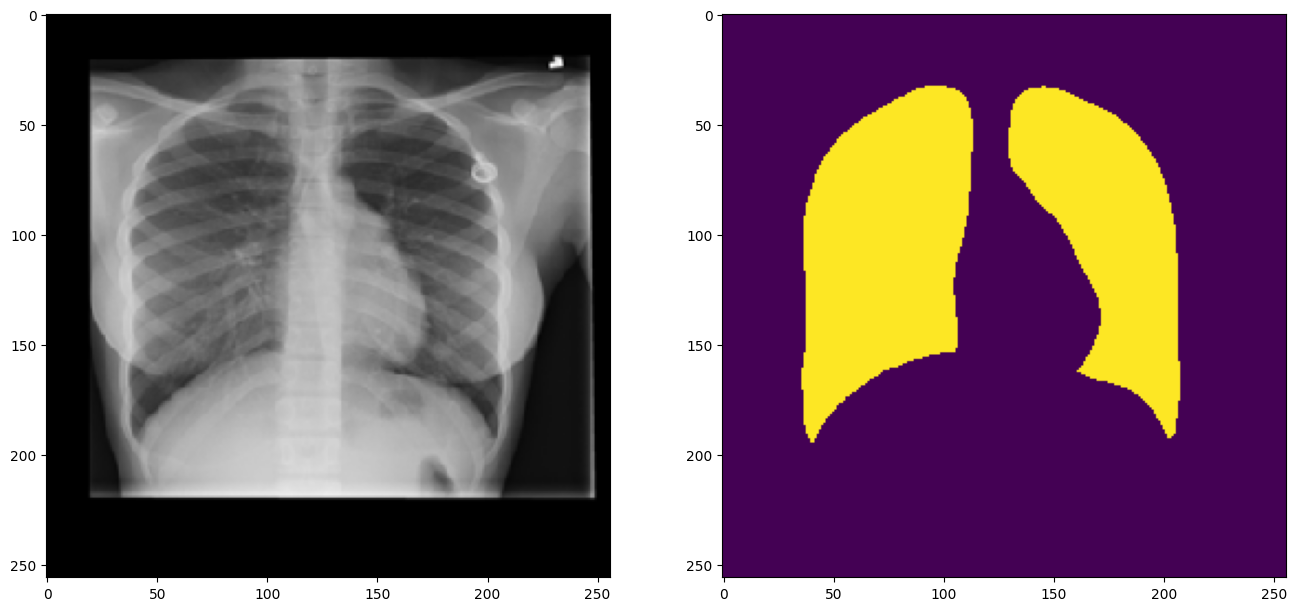

In [ ]:
original_image = os.path.join(dataset_path, image_dir, 'Normal-1.png')       # путь до ориганального изображения
label_image_semantic = os.path.join(dataset_path, label_dir, 'Normal-1.png') # путь до маски

fig, axs = plt.subplots(1, 2, figsize=(16, 8))                          # задаем область для построения (канвас)

img = np.array(load_img(original_image, target_size=(256, 256), color_mode='rgb'))   # загружаем оригинальное изображение как RGB с 3 каналами
mask = np.array(load_img(label_image_semantic, target_size=(256, 256), color_mode='grayscale'))  # загружаем маску как "отеннки серого", т.е. в один канал

axs[0].imshow(img)  # отрисовываем оригинальное изображение
axs[0].grid(False)

axs[1].imshow(mask) # отрисовываем маску (одноканальное изображение, каждый класс отображается как отдельный цвет)
axs[1].grid(False)

### Создание датасета для обучения

Датасет, который мы скачали, содержит набор картинок. Создадим массив (список) из ссылок на файлы с изображениями `input_img_path` и масками `target_img_path`. Для этого используем генератор списков с условием для проверки расширения в имени файла. Ссылки сортируем, чтобы обеспечить, что с одним и тем же индексом оба списка будут содержать верные пары изображения-маски.

In [ ]:
input_img_path = sorted(
    [
        os.path.join(dataset_path, image_dir, fname)
        for fname in os.listdir(os.path.join(dataset_path, image_dir))
        if fname.endswith(".png")
    ]
)

target_img_path = sorted(
    [
        os.path.join(dataset_path, label_dir, fname)
        for fname in os.listdir(os.path.join(dataset_path, label_dir))
        if fname.endswith(".png")
    ]
)

batch_size = 16
img_size = (128, 128) # Оригинальный размер 256х256 уменьшаем, т.к. ресурсы ограничены
IMG_CHANNELS = 3
NUM_CLASSES = 2

#### Использование генератора выборки **keras.utils.Sequence**

С помощью класса **keras.utils.Sequence** можно реализовать свой собственный генератор последовательности для обучающей выборки. Давайте посмотрим на конкретном примере как это можно сделать.

Предположим, мы хотим создавать ограниченные наборы выборок изображений цифр. Для этого определим производный класс **datasetGenerator**, следующим образом:

In [ ]:
# Генератор для перебора данных (в виде массивов Numpy)
class datasetGenerator(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_path, target_img_path = None, num_classes = NUM_CLASSES, validation = False):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_path = input_img_path
        self.target_img_path = target_img_path
        self.validation = validation


    def __len__(self):
        """Возвращает число мини-батчей обучающей выборки"""
        return len(self.target_img_path) // self.batch_size


    def __getitem__(self, idx):
        """Возвращает кортеж (input, target) соответствующий индексу пакета idx"""

        # Формируем пакеты из ссылок путем среза длинной в batch_size и возвращаем пакет по индексу
        batch_input_img_path = self.input_img_path[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_target_img_path = self.target_img_path[idx*self.batch_size:(idx+1)*self.batch_size]

        # Создадим массив numpy, заполненный нулями, для входных данных формы (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, 3) и типа данных float32
        x = np.zeros((self.batch_size, *self.img_size, 3), dtype="float32")

        # Создадим массив numpy, заполненный нулями, для выходных данных формы (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, 1) и типа данных uint8
        y = np.zeros((self.batch_size, *self.img_size, NUM_CLASSES), dtype="uint8")

        # В цикле заполняем массивы с изображениями x и y
        # Перебираем пакеты из путей batch_input_img_path и batch_target_img_path к изображениям
        # zip возвращает для нескольких последовательностей список кортежей из элементов последовательностей с одинаковыми индексами
        for _, paths in enumerate(zip(batch_input_img_path, batch_target_img_path)):

            # Загружаем изображение и маску используя путь файловой системы
            img = np.array(load_img(paths[0], target_size=self.img_size, color_mode='rgb'))         # 3 канала для изображения
            mask = np.array(load_img(paths[1], target_size=self.img_size, color_mode='grayscale'))  # 1 канал для маски

            if self.validation == False:
                # Применяем аугментацию для проверочной выборки (p - вероятность применения, 0.5 - для каждого второго изображения)
                transform = A.Compose([ # определяем функцию аугментации
                                A.HorizontalFlip(p=0.5),  # Горизонтальное отражение изображения
                                A.VerticalFlip(p=0.5),
                                A.RandomRotate90(p=0.5) # Случайный поворот на 90 градусов
                                 ])
                transformed = transform(image=img, mask=mask) # применяем функцию аугментации в изображению и маске
                img = transformed["image"]
                mask = transformed["mask"]
            # Преобразуем маску: заменяем 255 на 1
            mask = np.where(mask == 255, 1, mask)
            x[_] = img / 255 # нормализуем изображение
            y[_] = to_categorical(mask, num_classes=NUM_CLASSES) # преобразует маску из целых чисел в двоичную матрицу класса

        return x, y

In [ ]:
np.unique(mask)

array([  0, 255], dtype=uint8)

Перемешаем данные с одним и тем же `seed`, чтобы сохранить соответствие изображений и масок по одному индексу.

In [ ]:
seed = 1523
random.Random(seed).shuffle(input_img_path)
random.Random(seed).shuffle(target_img_path)

Расщепим наш датасет на обучающую и проверочную выборки. Из файла README.md.txt узнаем, что датасет содержит 10192 изображения легких в нормальном состоянии.
На проверочную выборку возьмем всего 1000 изображений.

In [ ]:
val_samples = 1000

# Расщепим наш датасет  на обучающую и проверочные выборки
train_input_img_path = input_img_path[:-val_samples]
train_target_img_path = target_img_path[:-val_samples]
val_input_img_path = input_img_path[-val_samples:]
val_target_img_path = target_img_path[-val_samples:]

Создадим экземпляры класса для нашего генератора выборки, инициализируем его расщепленными выше выборками.

In [ ]:
train_gen = datasetGenerator(batch_size, img_size, train_input_img_path, train_target_img_path, NUM_CLASSES)

val_gen = datasetGenerator(batch_size, img_size, val_input_img_path, val_target_img_path, NUM_CLASSES, validation = True)

### Архитектура сети U-net++

Unet ++ это мощная архитектура для сегментации медицинской изображения. Архитектура представляет собой глубоко подчеркнутую сеть энкодера-декодера, где подразделения энкодера и декодера соединены через серию вложенных, плотных путей пропуска. Переопределенные skip connecyions направлены на уменьшение семантического разрыва между картами признаков подразделения энкодера и декодера.

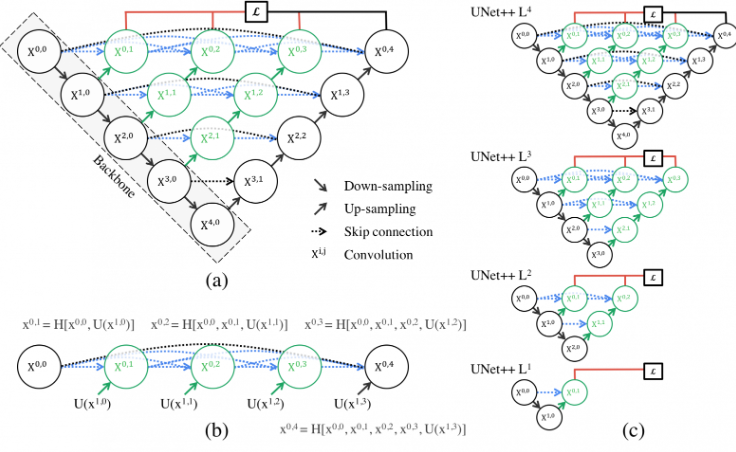

Параметры модели.

In [ ]:
LR = 0.001

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

NUM_EPOCHS=25

Построим архитектуру модели на.

In [ ]:
tf.keras.backend.clear_session()
nb_filter = [32,64,128,256,512]
inputs = Input((img_size[0], img_size[1], IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)


c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.5) (c1)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
c1 = Dropout(0.5) (c1)
p1 = MaxPooling2D((2, 2), strides=(2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.5) (c2)
c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
c2 = Dropout(0.5) (c2)
p2 = MaxPooling2D((2, 2), strides=(2, 2)) (c2)

up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(c2)
conv1_2 = concatenate([up1_2, c1], name='merge12', axis=3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_2)
c3 = Dropout(0.5) (c3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
c3 = Dropout(0.5) (c3)

conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
conv3_1 = Dropout(0.5) (conv3_1)
conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_1)
conv3_1 = Dropout(0.5) (conv3_1)
pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
conv2_2 = concatenate([up2_2, c2], name='merge22', axis=3) #x10
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Dropout(0.5) (conv2_2)
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Dropout(0.5) (conv2_2)

up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
conv1_3 = concatenate([up1_3, c1, c3], name='merge13', axis=3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Dropout(0.5) (conv1_3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Dropout(0.5) (conv1_3)

conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool3)
conv4_1 = Dropout(0.5) (conv4_1)
conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_1)
conv4_1 = Dropout(0.5) (conv4_1)
pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3) #x20
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Dropout(0.5) (conv3_2)
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Dropout(0.5) (conv3_2)

up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
conv2_3 = concatenate([up2_3, c2, conv2_2], name='merge23', axis=3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)

up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
conv1_4 = concatenate([up1_4, c1, c3, conv1_3], name='merge14', axis=3)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)

conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool4)
conv5_1 = Dropout(0.5) (conv5_1)
conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5_1)
conv5_1 = Dropout(0.5) (conv5_1)

up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3) #x30
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)

up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)

up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], name='merge24', axis=3)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)

up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
conv1_5 = concatenate([up1_5, c1, c3, conv1_3, conv1_4], name='merge15', axis=3)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)

nestnet_output_4 = Conv2D(2, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal',  name='output_4', padding='same')(conv1_5)

model = Model([inputs], [nestnet_output_4])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=bce_dice_loss)

In [ ]:
model.summary() # отчет о структуре модели

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ lambda[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ dropout_3[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_6[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool3               │ (None, 16, 16,    │          0 │ dropout_7[0][0] 

 Total params: 9,042,210 (34.49 MB)

 Trainable params: 9,042,210 (34.49 MB)

 Non-trainable params: 0 (0.00 B)

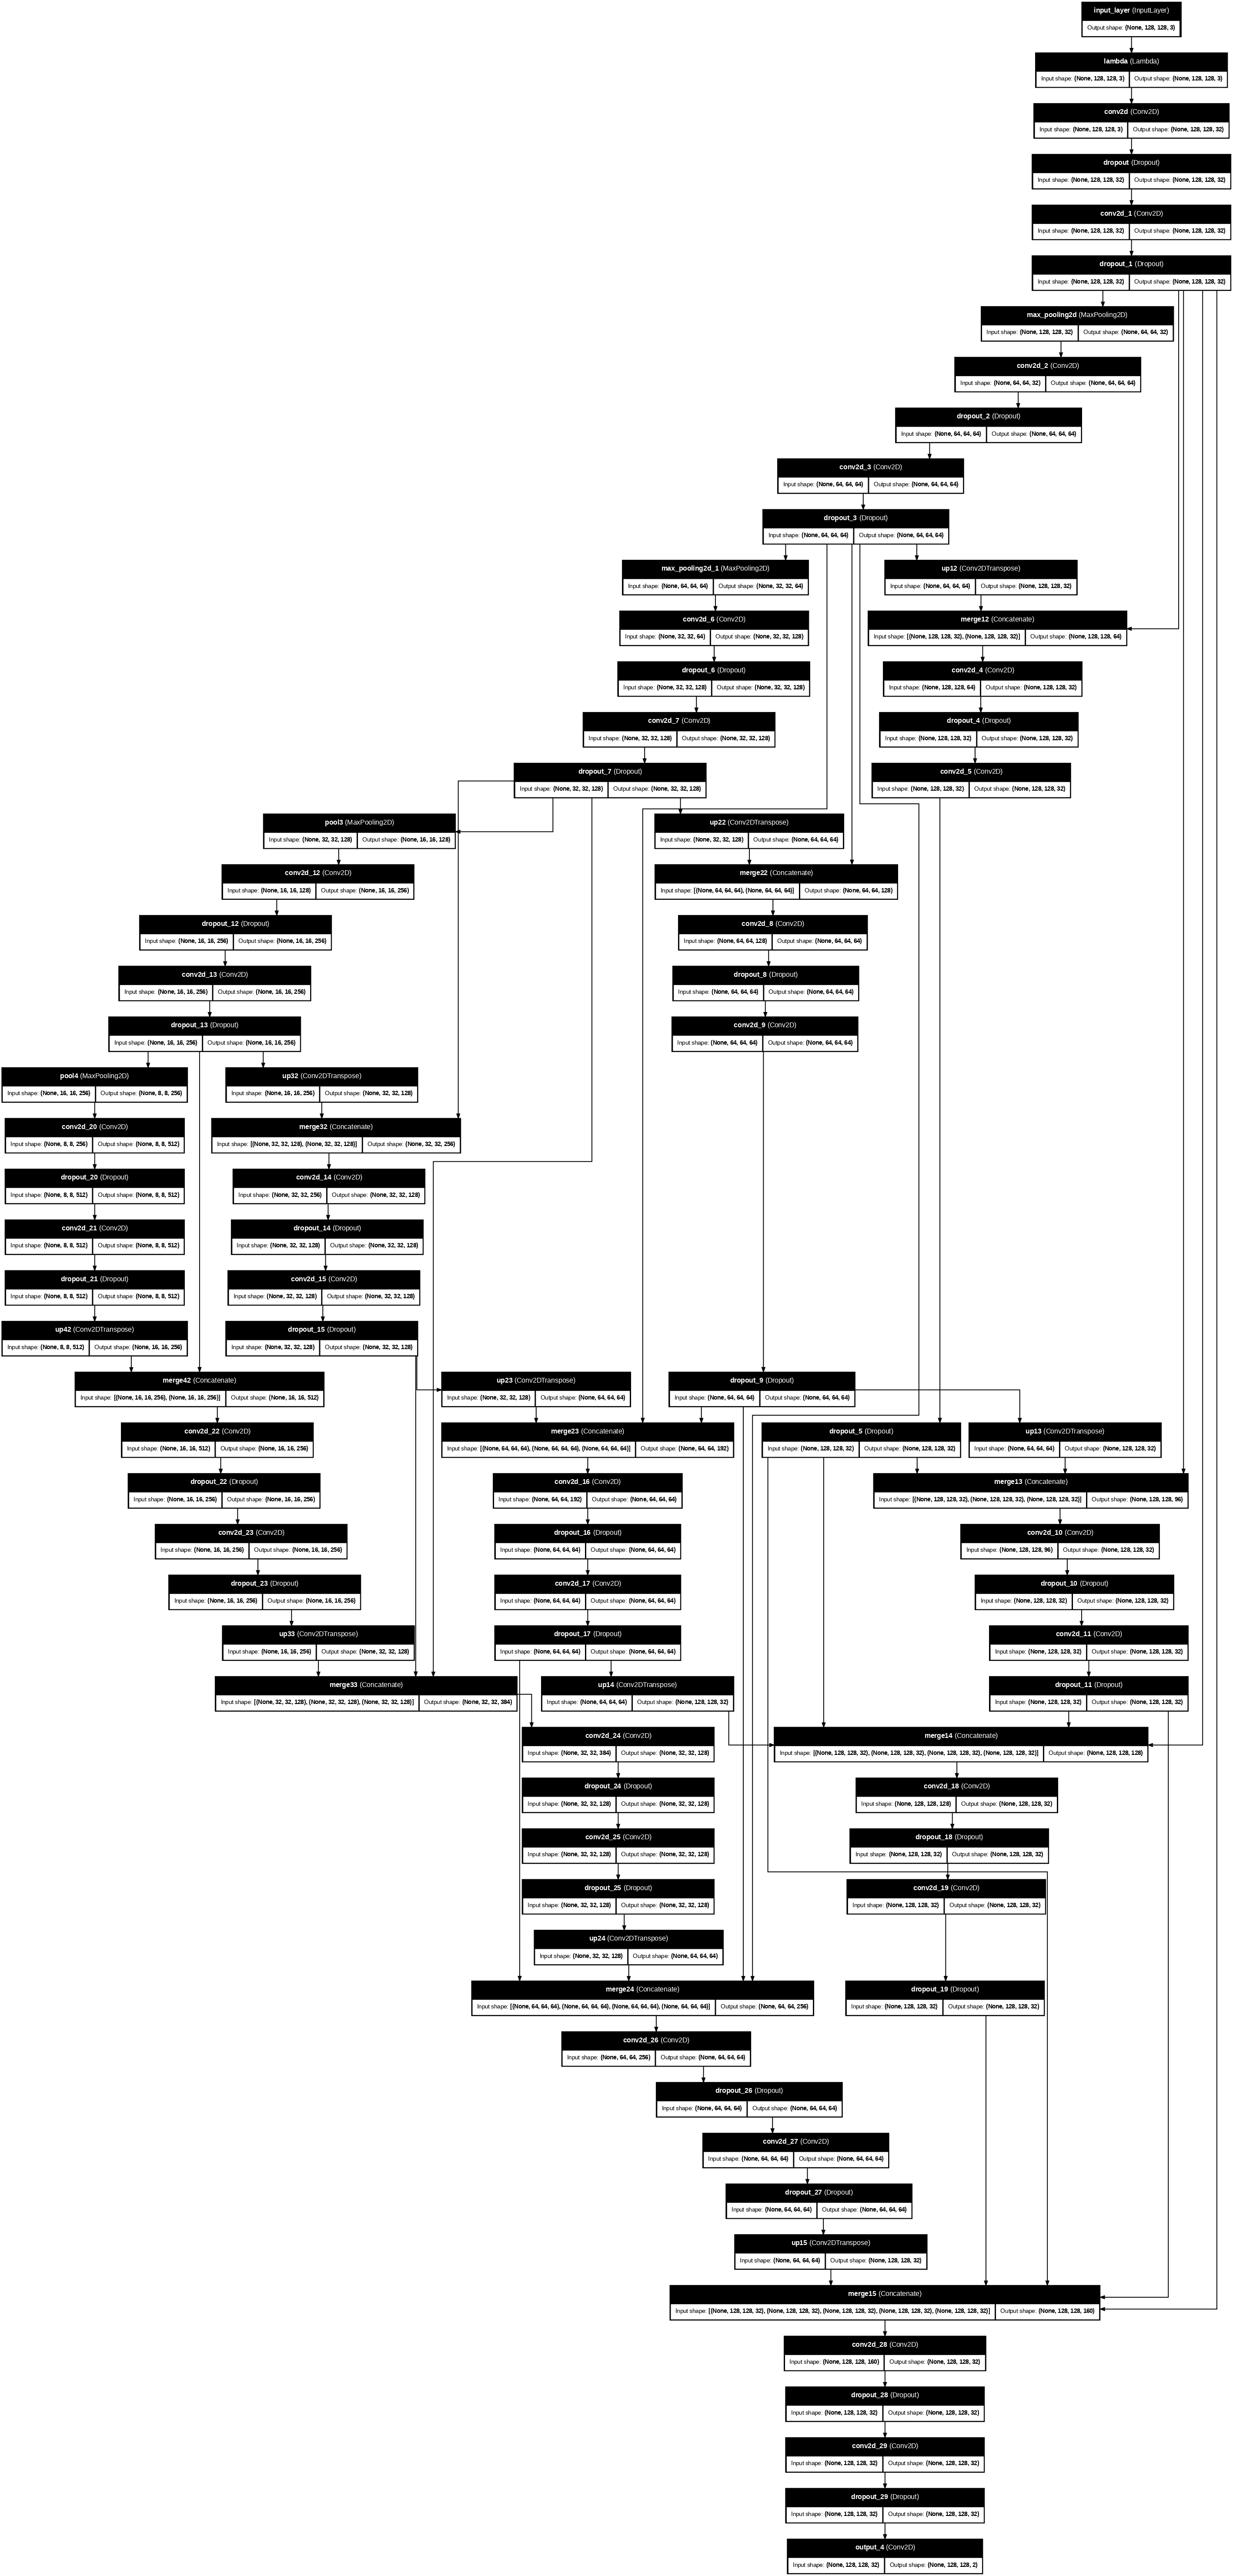

In [ ]:
# график структуры модели
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=70)

### Обучение модели

Теперь мы можем обучить нашу модель, передав ей экземпляры класса генератора выборки для обучающей и проверочной выборок. Обучать будем на 50 эпохах.

In [ ]:
checkpoint = ModelCheckpoint('best_model.weights.h5' ,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only=True,
                             mode = 'min',
                             save_weights_only=True,
                             save_freq='epoch'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.00005)

callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_gen,
                    validation_data=val_gen,
                    validation_steps=10,
                    batch_size=batch_size,
                    callbacks=callbacks_list,
                    epochs=NUM_EPOCHS,
                    verbose=1,)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: -0.7340
Epoch 1: val_loss improved from inf to -0.83054, saving model to best_model.weights.h5
574/574 ━━━━━━━━━━━━━━━━━━━━ 165s 229ms/step - loss: -0.7343 - val_loss: -0.8305 - learning_rate: 0.0010
Epoch 2/25
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: -0.9399
Epoch 2: val_loss improved from -0.83054 to -0.93729, saving model to best_model.weights.h5
574/574 ━━━━━━━━━━━━━━━━━━━━ 141s 246ms/step - loss: -0.9399 - val_loss: -0.9373 - learning_rate: 0.0010
Epoch 3/25
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: -0.9497
Epoch 3: val_loss did not improve from -0.93729
574/574 ━━━━━━━━━━━━━━━━━━━━ 128s 223ms/step - loss: -0.9497 - val_loss: -0.8540 - learning_rate: 0.0010
Epoch 4/25
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: -0.9569
Epoch 4: val_loss improved from -0.93729 to -0.95082, saving model to best_model.weights.h5
574/574 ━━━━━━━━━━━━━━━━━━━━ 129s 224ms/step - loss: -0.9569 - val_loss: -0.9508 - learning_rate:

### Анализ результатов обучения

Посмотрим на график точности и функцию ошибки. Видно, что еще точность далека от насыщения и можно продолжать обучение. Переобучения пока нет.

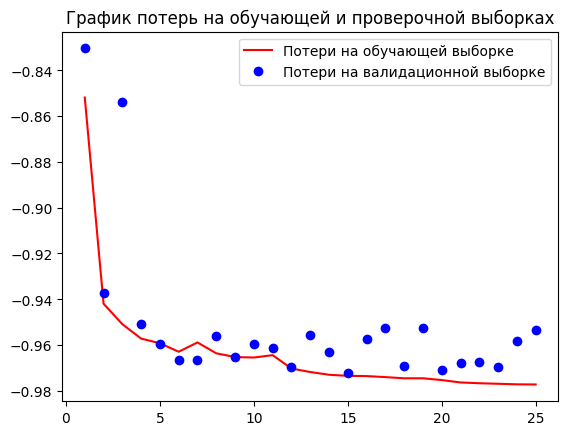

In [ ]:
loss = history.history['loss']                                             # данные об ошибке на обучающей выборке
val_loss = history.history['val_loss']                                     # данные об ошибке на проверочной выборке
epochs = range(1, len(loss) + 1)                                            # массив со значениями для оси абсцисс (Х)
plt.figure()                                                               #  создаем новую фигуру (полотно для графика)
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           #  строим график потерь (ошибки) на обучающей выборке
plt.plot(epochs, val_loss, 'bo', label='Потери на валидационной выборке')  #  строим график потерь на проверочной выборке
plt.title('График потерь на обучающей и проверочной выборках')             #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.show()

### Визуальная оценка результата сегментации на тестовой выборке

Сравним оригинальную маску и предсказанную маску на тестовой выборке.

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная маска']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[0])            # отображаем картинку
    plt.imshow(display_list[i],alpha=0.8)  # отображаем маску с прозрачностью 80%
    plt.axis('off')
  plt.show()

Определим функцию создания маски и отобразим 10 образцов изображений, а также соответствующих им оригинальные и предсказанные маски.

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


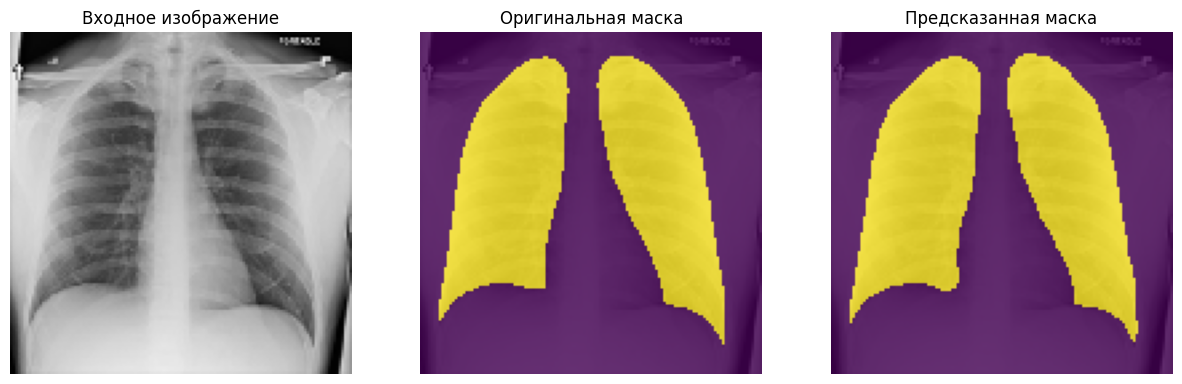

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


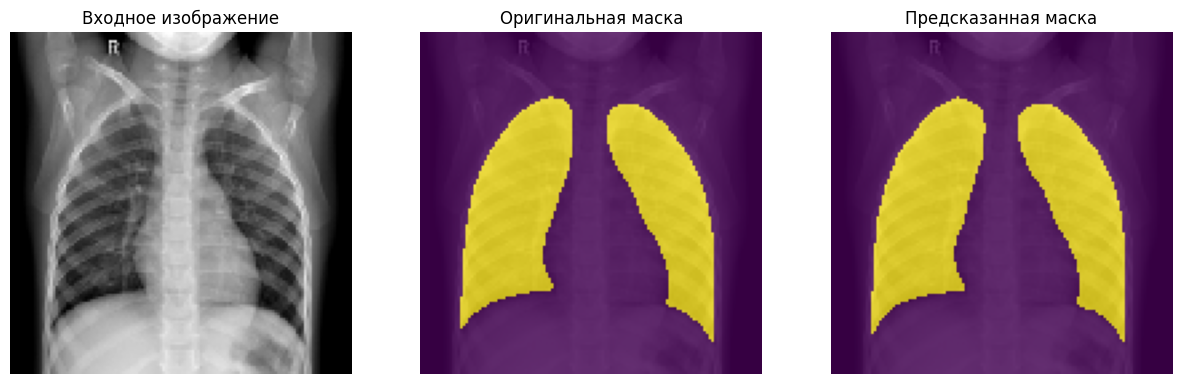

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


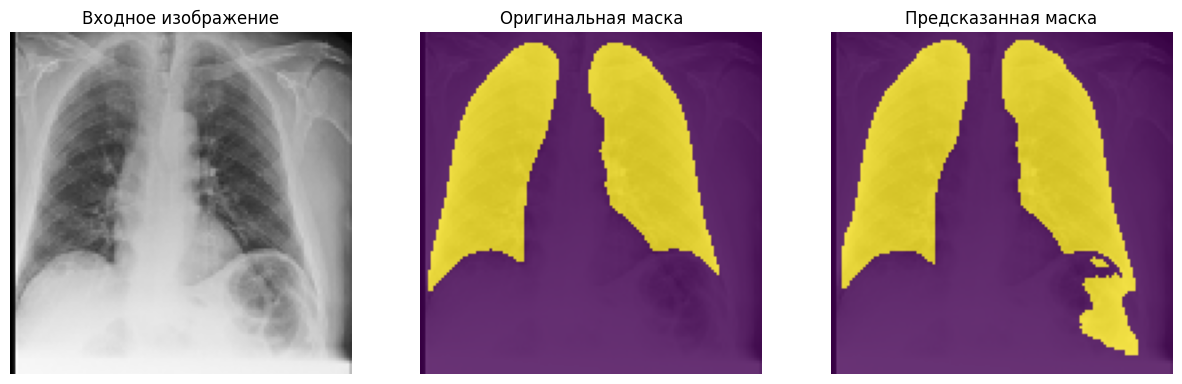

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


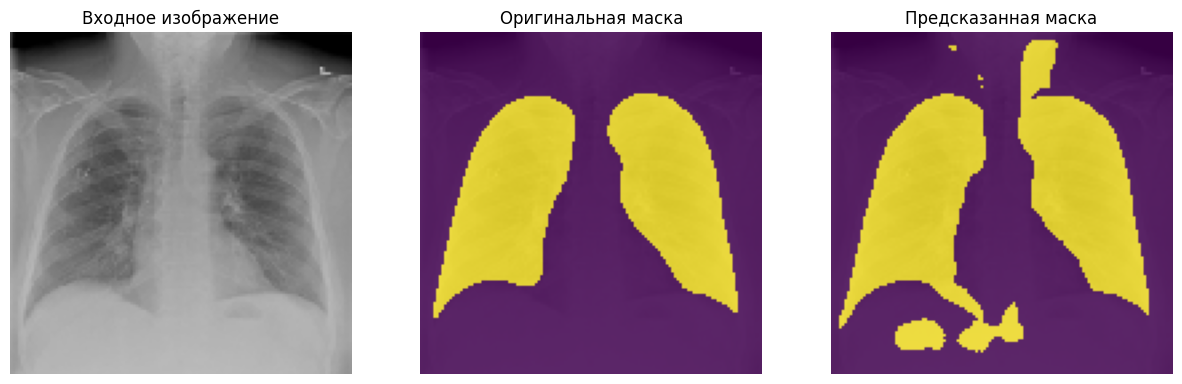

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


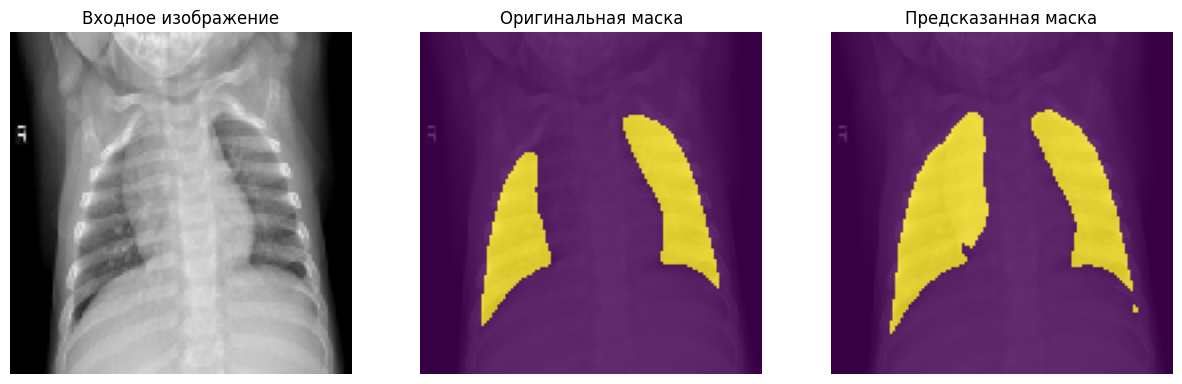

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


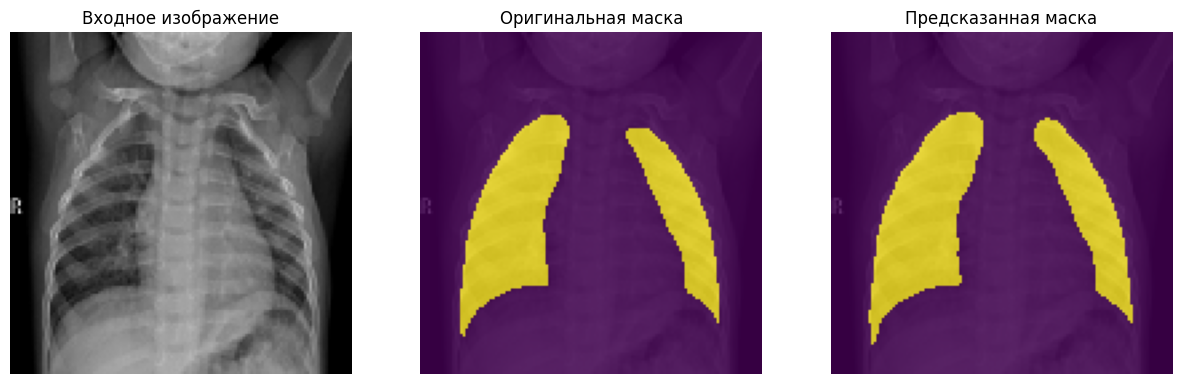

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


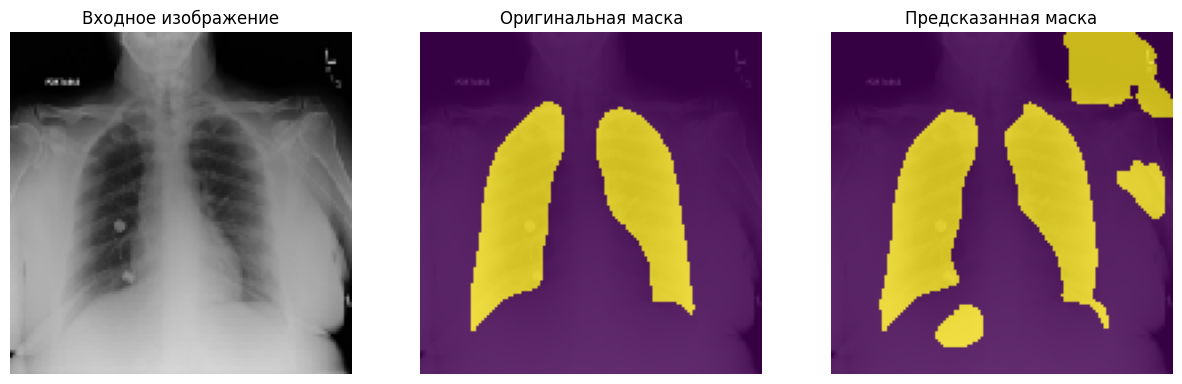

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


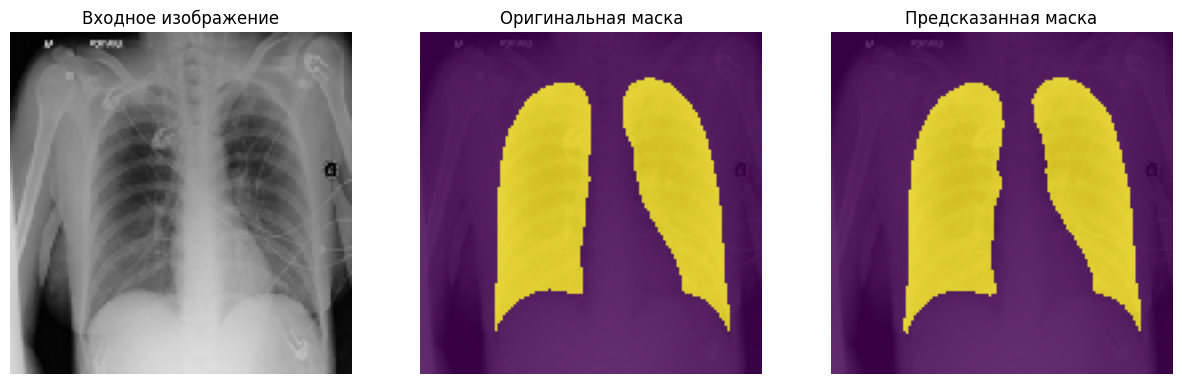

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


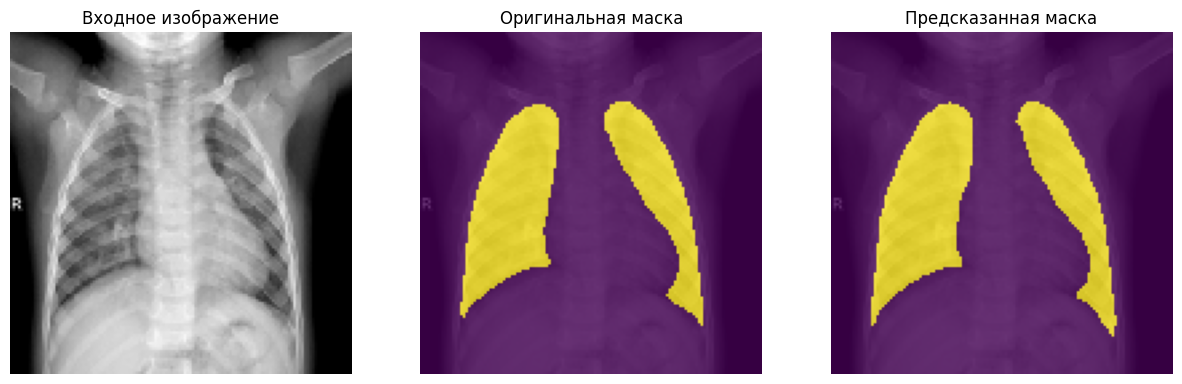

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


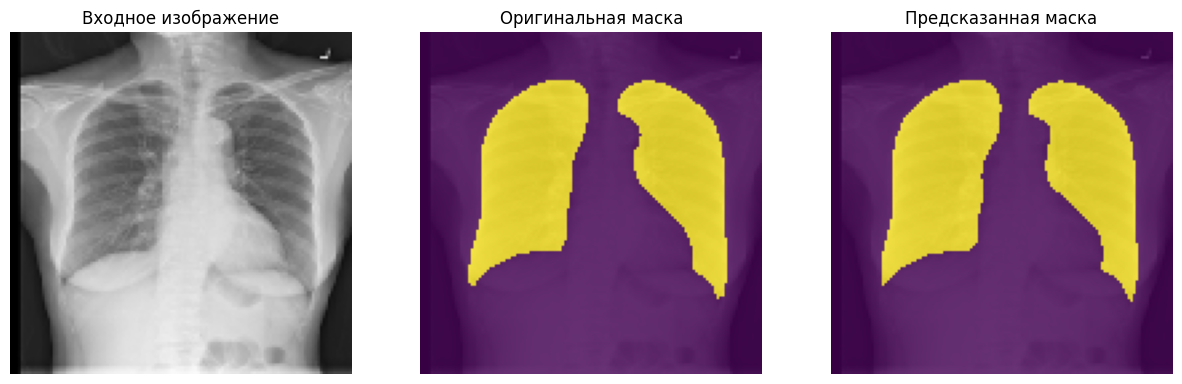

In [ ]:
for index in range(10):                  # выбираем 10 картинок и выводим их в цикле
    img = np.array(load_img(val_input_img_path[index], target_size=(128, 128), color_mode='rgb')) # загружаем картинку для предсказания
    mask = np.array(load_img(val_target_img_path[index], target_size=(128, 128), color_mode='grayscale')) # загружаем маску для сравнения с предсказанием

    # Запускаем модель в режиме предсказания
    test = model.predict(np.expand_dims(img, 0) / 255)

    # Выбираем наиболее веротный класс
    test = np.argmax(test, axis=-1)

    display([img.reshape(1, 128, 128, 3)[0], mask, test[0]])  # передаем в функцию display изображение, оригинальную маску и предсказанную